In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.color import rgb2lab, deltaE_cie76
import os
import cvlib as cv
from cvlib.object_detection import draw_bbox
import PIL.Image as pilimg
import glob

%matplotlib inline

Using TensorFlow backend.


# 경로 내 이미지 파일의 Bounding box 좌표 추출

In [2]:
file_list = glob.glob('C:\\Users\\mb910\\mulcam_project\\dataset\\clothing-co-parsing\\photos\\*')[:10]
box_dict={}


for idx, file in enumerate(file_list):
    bg = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    bbox, label, conf = cv.detect_common_objects(bg)
    box_dict[idx] = [bbox, label, conf]

bbox = []
for i in range(len(box_dict)):
    bbox.append(box_dict[i][0][box_dict[i][1].index('person')])

# Background 와 Object 분리해서 fsh_dataset에 list 형태로 저장

In [3]:
fsh_dataset = {}
cloth_clr = []
bg_clr = []
for idx, file in enumerate(file_list):    
    im = pilimg.open(file)
    bg = np.array(im)
    cloth = bg.copy()[bbox[idx][1]:bbox[idx][3], bbox[idx][0]:bbox[idx][2]]
    cloth_clr.append(cloth.tolist())
    bg[bbox[idx][1]:bbox[idx][3], bbox[idx][0]:bbox[idx][2]] = -1 # 해당 부분의 RGB값을 [255,255,255]로 변경
    bg_clr.append(bg.tolist())

fsh_dataset['target'] = cloth_clr
fsh_dataset['data'] = bg_clr

# Background 에서 RGB [255,255,255] 제거

In [4]:
for idx in range(len(fsh_dataset['data'])):
    for i in range(len(fsh_dataset['data'][idx])):
        fsh_dataset['data'][idx][i] = list(filter(lambda x: x!= [255,255,255], fsh_dataset['data'][idx][i]))

# Kmeans 모델 fitting

In [5]:
clt = KMeans(n_clusters=5)
clt2 = KMeans(n_clusters=5)

clt.fit(sum(fsh_dataset['data'][1], []))  # Background 대표 색상 추출을 위한 모델 fitting
clt2.fit(sum(fsh_dataset['target'][1], []))  # Object 대표 색상 추출을 위한 모델 fitting

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# 대표 색상 시각화 ( 위: background // 아래 : object)

In [6]:
def find_histogram(clt):
    """
    create a histogram with k clusters
    :param: clt
    :return:hist
    """
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist
def plot_colors2(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

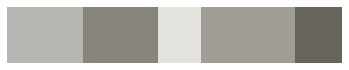

In [7]:
hist = find_histogram(clt)
bar = plot_colors2(hist, clt.cluster_centers_)
plt.axis("off")
plt.imshow(bar)
plt.show()

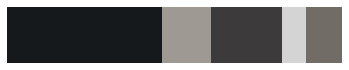

In [8]:
hist = find_histogram(clt2)
bar = plot_colors2(hist, clt2.cluster_centers_)
plt.axis("off")
plt.imshow(bar)
plt.show()

In [9]:
clt.cluster_centers_

array([[183.27162996, 182.35957164, 178.69819397],
       [135.37283496, 132.41243969, 123.82554435],
       [227.81345178, 226.66975375, 220.89955719],
       [159.30524055, 157.30049092, 150.49586402],
       [103.6200495 , 101.49482219,  92.28995757]])

In [10]:
clt2.cluster_centers_

array([[ 22.61178078,  25.47543414,  27.93101448],
       [158.69440261, 153.96604926, 146.38302463],
       [ 60.47970678,  58.32803125,  59.25019812],
       [211.81446898, 212.15743748, 211.39054888],
       [114.19701727, 108.90345369, 103.50476564]])